In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
__title__ = ''
__author__ = 'liuminge'
__mtime__ = '2019/04/29'
"""

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import itertools

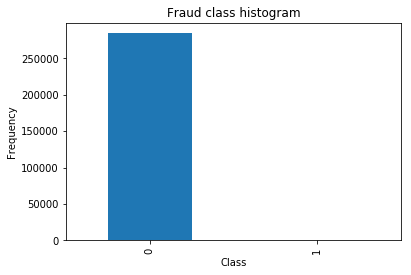

In [4]:
# 导入csv数据
data = pd.read_csv("creditcard.csv")
# print(data.head())


# 查看类别的占比
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [5]:
# 将Amount特征进行标准化，并且删除掉不需要的Time特征
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)
# print(data.head())


# 采用下采样策略解决样本不均衡问题
X = data.iloc[:, data.columns != 'Class']
Y = data.iloc[:, data.columns == 'Class']


# Number of data points in the minority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)


# Picking the indices of the normal classes
normal_indices = data[data.Class == 0].index


# Out of the indices we picked, randomly select "x" number(number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)


# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])


# Under sample dataset
under_sample_data = data.iloc[under_sample_indices, :]


X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
Y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [6]:
# Whole dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


print("")
print("Number transactions train dataset: ", len(X_train))
print("Number transactions test dataset: ", len(X_test))
print("Total member of transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
print("")
X_train_undersample, X_test_undersample, Y_train_undersample, Y_test_undersample = train_test_split(X_undersample, Y_undersample, test_size=0.3, random_state=0)
print("Number transactions undersample train dataset: ", len(X_train_undersample))
print("Number transactions undersample test dataset: ", len(X_test_undersample))
print("Total member of undersample transactions: ", len(X_train_undersample)+len(X_test_undersample))
print("")


Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total member of transactions:  284807

Number transactions undersample train dataset:  688
Number transactions undersample test dataset:  296
Total member of undersample transactions:  984



--------------------------------------------------
C parameter:  0.01
--------------------------------------------------

Iteration 1 : recall score =  0.8767123287671232 :f1_score= 0.9142857142857143
Iteration 2 : recall score =  0.9041095890410958 :f1_score= 0.88
Iteration 3 : recall score =  0.9661016949152542 :f1_score= 0.957983193277311
Iteration 4 : recall score =  0.9459459459459459 :f1_score= 0.9271523178807948
Iteration 5 : recall score =  0.9242424242424242 :f1_score= 0.9242424242424242

Mean recall score:  0.9234223965823688
Mean f1 score: 0.9207327299372488

--------------------------------------------------
C parameter:  0.1
--------------------------------------------------

Iteration 1 : recall score =  0.8493150684931506 :f1_score= 0.9117647058823529
Iteration 2 : recall score =  0.8904109589041096 :f1_score= 0.8904109589041096
Iteration 3 : recall score =  0.9661016949152542 :f1_score= 0.9827586206896551
Iteration 4 : recall score =  0.9459459459459459 :f1_score= 0.939

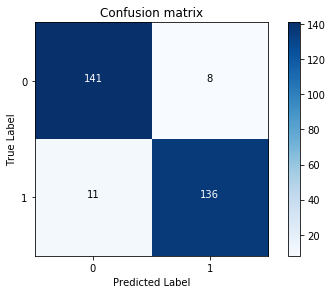

-----------------------------------------------------------------------


In [11]:
# Recall = TP/(TP+FN)---召回率
# K-折交叉验证选择最优的正则化参数
def printing_KFold_scores(X_train_data, Y_train_data):
	kf = KFold(5, shuffle=False)

	# Different C parameters
	c_param_range = [0.01, 0.1, 1, 10, 100]

	result_table = pd.DataFrame(index=range(len(c_param_range), 2), columns=['C_parameter', 'Mean recall score'])
	result_table['C_parameter'] = c_param_range

	# the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
	j = 0
	for c_param in c_param_range:
		print("--------------------------------------------------")
		print("C parameter: ", c_param)
		print("--------------------------------------------------")
		print("")

		result_accs = []
		result_f1=[]
		for iteration, indices in enumerate(kf.split(Y_train_data), start=1):

			# Call the logistic regeression model with a certain C parameter
			lr = LogisticRegression(C=c_param, solver='liblinear', penalty='l2')

			# Use the training data to fit the model. In this case, we use the portion of the fold to train the model
			# with indices[0]. We then predict on the portion assigned as the test cross validation with indices[1]
			lr.fit(X_train_data.iloc[indices[0], :], Y_train_data.iloc[indices[0], :].values.ravel())

			# Predict values using the test indices in the training data
			Y_pred_undersample = lr.predict(X_train_data.iloc[indices[1], :].values)

			# Calculate the recall score and append it to a list for recall scores representing the current c_parameter
			recall_acc = recall_score(Y_train_data.iloc[indices[1], :].values, Y_pred_undersample)
			f1_acc=f1_score(Y_train_data.iloc[indices[1], :].values, Y_pred_undersample)
			result_accs.append(recall_acc)
			result_f1.append(f1_acc)
			print('Iteration', iteration, ': recall score = ', recall_acc,':f1_score=',f1_acc)

		# The mean value of those recall scores in the metric we want to save and get hold of.
		result_table.loc[j, 'Mean recall score'] = np.mean(result_accs)
		result_table.loc[j,'Mean f1 score']=np.mean(result_f1)
		j += 1
		print("")
		print("Mean recall score: ", np.mean(result_accs))
		print("Mean f1 score:",np.mean(result_f1))
		print("")

	result_table['Mean recall score'] = result_table['Mean recall score'].astype('float64')
	result_table['Mean f1 score']=result_table['Mean f1 score'].astype('float64')
# 	best_c = result_table.loc[result_table['Mean recall score'].idxmax()]['C_parameter']
	best_c = result_table.loc[result_table['Mean f1 score'].idxmax()]['C_parameter']
	# Finally, we can check with C parameter is the best among the chosen
	print("********************************************************************************")
	print("Best model to choose from cross validation is with C parameter = ", best_c)
	print("********************************************************************************")

	return best_c


# 输出最优的正则化参数
best_c = printing_KFold_scores(X_train_undersample, Y_train_undersample)
print(best_c)
print("")


# 绘制混淆矩阵函数
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
	"""
	This function prints and plots the confusion matrix.
	:param cm:
	:param classes:
	:param title:
	:param cmap:
	:return:
	"""
	plt.imshow(cm, interpolation='nearest', cmap=cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation=0)
	plt.yticks(tick_marks, classes)

	thresh = cm.max() / 2
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j],
				 horizontalalignment='center',
				 color='white' if cm[i, j] > thresh else "black")

	plt.tight_layout()
	plt.ylabel("True Label")
	plt.xlabel("Predicted Label")


lr = LogisticRegression(C=best_c, solver='liblinear', penalty='l2')
lr.fit(X_train_undersample, Y_train_undersample.values.ravel())
Y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test_undersample, Y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset(下采样测试集): ", cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix(在下采样的测试集上进行测试)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
					classes=class_names,
					title='Confusion matrix')
plt.show()


print("-----------------------------------------------------------------------")

Recall metric in the testing dataset(整个测试集):  0.9387755102040817
f1 score in the testing dataset(整个测试集): 0.06855439642324888


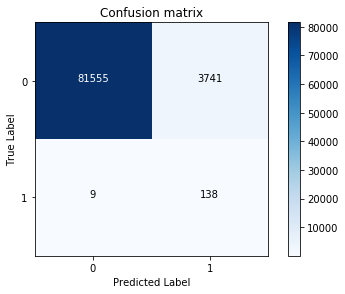

------------------------------------------------------------------------
--------------------------------------------------
C parameter:  0.01
--------------------------------------------------

Iteration 1 : recall score =  0.5522388059701493 :f1_score= 0.6607142857142858
Iteration 2 : recall score =  0.6164383561643836 :f1_score= 0.7377049180327868
Iteration 3 : recall score =  0.7 :f1_score= 0.7636363636363636
Iteration 4 : recall score =  0.6153846153846154 :f1_score= 0.7407407407407407
Iteration 5 : recall score =  0.475 :f1_score= 0.6178861788617886

Mean recall score:  0.5918123555038297
Mean f1 score: 0.7041364973971932

--------------------------------------------------
C parameter:  0.1
--------------------------------------------------

Iteration 1 : recall score =  0.582089552238806 :f1_score= 0.6842105263157895
Iteration 2 : recall score =  0.6027397260273972 :f1_score= 0.7272727272727272
Iteration 3 : recall score =  0.6666666666666666 :f1_score= 0.7407407407407408
Iterat

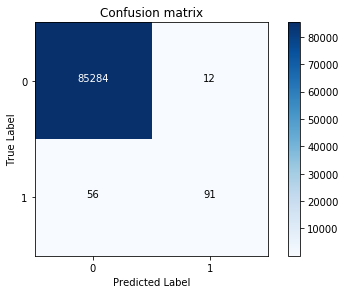

-----------------------------------------------------------------------


In [12]:
lr = LogisticRegression(C=best_c, solver='liblinear', penalty='l2')
lr.fit(X_train_undersample, Y_train_undersample.values.ravel())
Y_pred = lr.predict(X_test.values)

# Compare confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset(整个测试集): ", cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1]))
P=cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1])
R=cnf_matrix[1, 1]/(cnf_matrix[0, 1]+cnf_matrix[1, 1])
f1_a=2/(1/P+1/R)
print("f1 score in the testing dataset(整个测试集):",f1_a)
# Plot non-normalized confusion matrix(在整个测试集上进行测试)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
					  classes=class_names,
					  title='Confusion matrix')
plt.show()


print("------------------------------------------------------------------------")


best_c = printing_KFold_scores(X_train, Y_train)
print(best_c)

lr = LogisticRegression(C=best_c, solver='liblinear', penalty='l2')
lr.fit(X_train, Y_train.values.ravel())
Y_pred_undersample = lr.predict(X_test.values)


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset(整个测试集): ", cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1]))
P=cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1])
R=cnf_matrix[1, 1]/(cnf_matrix[0, 1]+cnf_matrix[1, 1])
f1_a=2/(1/P+1/R)
print("f1 score in the testing dataset(整个测试集):",f1_a)
# Plot non-normalized confusion matrix(在不进行下采样(即不均衡类别)的测试集上进行测试)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
						classes=class_names,
						title='Confusion matrix')

plt.show()


print("-----------------------------------------------------------------------")


Recall metric in the testing dataset(下采样测试集):  1.0
Recall metric in the testing dataset(下采样测试集):  1.0
Recall metric in the testing dataset(下采样测试集):  0.9931972789115646
Recall metric in the testing dataset(下采样测试集):  0.9795918367346939
Recall metric in the testing dataset(下采样测试集):  0.9251700680272109
Recall metric in the testing dataset(下采样测试集):  0.891156462585034
Recall metric in the testing dataset(下采样测试集):  0.8571428571428571
Recall metric in the testing dataset(下采样测试集):  0.8231292517006803
Recall metric in the testing dataset(下采样测试集):  0.7891156462585034


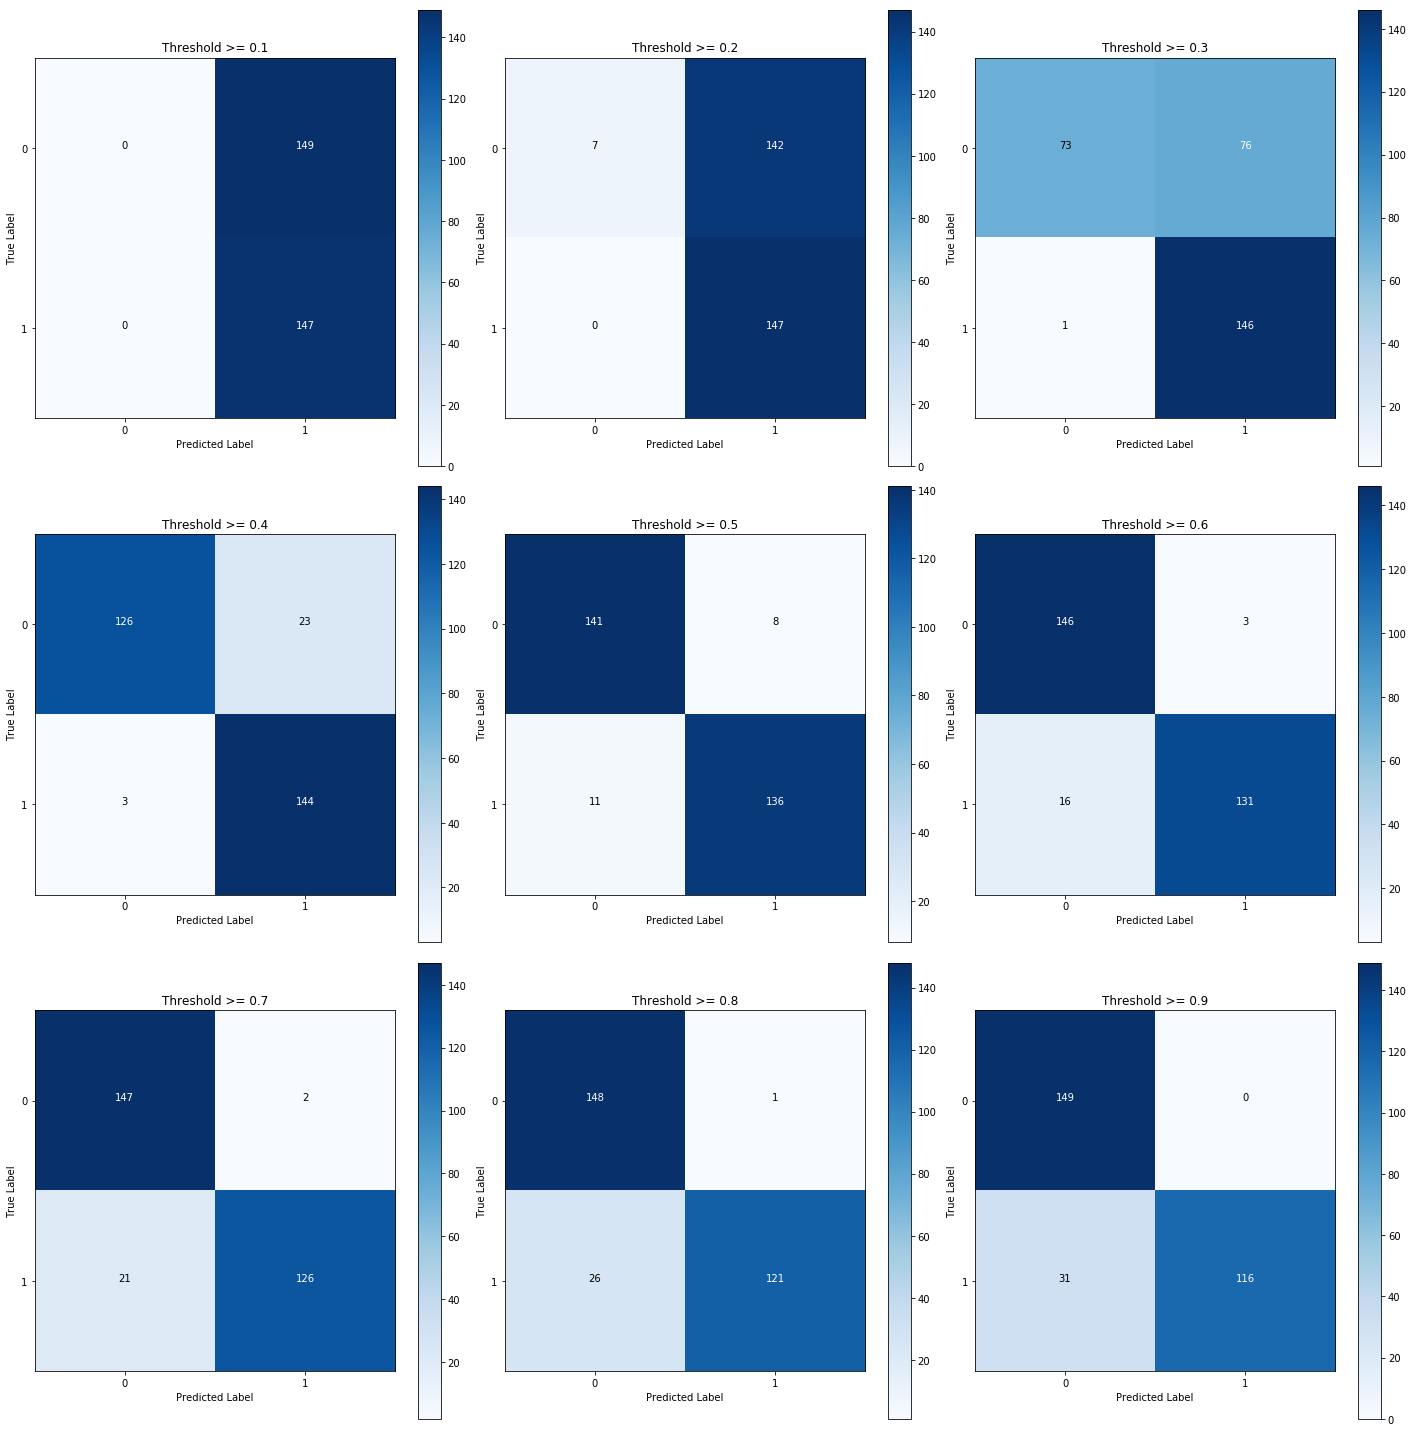

--------------------------------------------------------------------


In [13]:
# 逻辑回归的阈值对结果的影响(通过matplotlib绘图可视化出来)
print("")
lr = LogisticRegression(C=0.01, solver='liblinear', penalty='l2')
lr.fit(X_train_undersample, Y_train_undersample.values.ravel())
Y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(20, 20))

j = 1
for i in thresholds:
	Y_test_predictions_high_recall = Y_pred_undersample_proba[:, 1] > i

	plt.subplot(3, 3, j)
	j += 1

	# Compute confusion matrix(为了节约时间，在下采样测试集上可视化阈值的影响)
	cnf_matrix = confusion_matrix(Y_test_undersample, Y_test_predictions_high_recall)
	np.set_printoptions(precision=2)

	print("Recall metric in the testing dataset(下采样测试集): ", cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1]))

	# Plot non-normalized confusion matrix
	class_names = [0, 1]
	plot_confusion_matrix(cnf_matrix,
						  classes=class_names,
						  title='Threshold >= %s'%i)

plt.show()


print("--------------------------------------------------------------------")

227454
---------------------------------------------------------------------------
--------------------------------------------------
C parameter:  0.01
--------------------------------------------------

Iteration 1 : recall score =  0.8838709677419355 :f1_score= 0.11156351791530944
Iteration 2 : recall score =  0.9078947368421053 :f1_score= 0.11567476948868399
Iteration 3 : recall score =  0.9436538674338829 :f1_score= 0.9635714447131138
Iteration 4 : recall score =  0.894901133203636 :f1_score= 0.9445359628770301
Iteration 5 : recall score =  0.8936591156395292 :f1_score= 0.9438437026589355

Mean recall score:  0.9047959641722179
Mean f1 score: 0.6158378795306145

--------------------------------------------------
C parameter:  0.1
--------------------------------------------------

Iteration 1 : recall score =  0.8838709677419355 :f1_score= 0.11133685493701746
Iteration 2 : recall score =  0.9078947368421053 :f1_score= 0.11538461538461539
Iteration 3 : recall score =  0.94372026114

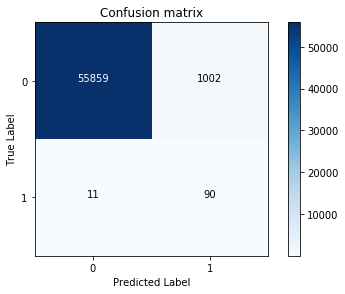

In [14]:
# 采用过采样方法来处理数据集
# SMOTE样本生成策略
credit_cards = pd.read_csv("creditcard.csv")

columns = credit_cards.columns

# The labels are in the last column("Class"). Simply remove it to obtain features columns
features_columns = columns.delete(len(columns)-1)

features = credit_cards[features_columns]
labels = credit_cards['Class']


features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=0)

oversampler = SMOTE(random_state=0)
os_features, os_labels = oversampler.fit_sample(features_train, labels_train)

print(len(os_labels[os_labels == 1]))

print("---------------------------------------------------------------------------")

os_features = pd.DataFrame(os_features)
os_labels = pd.DataFrame(os_labels)
best_c = printing_KFold_scores(os_features, os_labels)
print(best_c)

print("---------------------------------------------------------------------------")

lr = LogisticRegression(C=best_c, solver='liblinear', penalty='l2')
lr.fit(os_features, os_labels.values.ravel())
Y_pred = lr.predict(features_test.values)

# Compute confusion matrix(在整个过采样之后的测试集上)
cnf_matrix = confusion_matrix(labels_test, Y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset(在整个测试集上): ", cnf_matrix[1, 1]/(cnf_matrix[1, 0]+cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix(在进行SMOTE过采样的测试集上进行测试)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
					  classes=class_names,
					  title='Confusion matrix')

plt.show()